In [1]:
!rm -rf dl-projects
!git clone https://github.com/mengwangk/dl-projects
!cd dl-projects && ls 

Cloning into 'dl-projects'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 11.27 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (229/229), done.
01_1_tensor.ipynb	       07_algebra.ipynb      LICENSE
01_2_correlation.ipynb	       08_probability.ipynb  lstm_s1.ipynb
01_3_preprocessing.ipynb       09_evaluation.ipynb   lstm_s2.ipynb
01_4_numpy.ipynb	       50_RL.ipynb	     lstm_s3.ipynb
01_5_parallelization.ipynb     999_Links.ipynb	     lstm_s4.ipynb
02_1_feature_engineer.ipynb    archive		     lstm_s5.ipynb
02_2_feature_generation.ipynb  d01_download.ipynb    lstm_s6.ipynb
02_3_feature_generation.ipynb  d02_0_features.ipynb  notebook2script.py
03_1_feature_selection.ipynb   d02_1_features.ipynb  README.md
03_2_feature_selection.ipynb   d03_train_dl.ipynb    run_notebook.py
04_0_basic_nn.ipynb	       d04_train_ml.ipynb    scraper
04_1_cnn.ipynb		       dask-worker-space     stock.ipynb
04_2_rn

In [0]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path

In [0]:
# DATASET = Path("datasets/lotto/data_processed_2.csv")

DATASET = Path("dl-projects/datasets/lotto/data_processed.csv")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [0]:
# Read into data frame
dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['DrawDate'], dtype={'PrizeType': str})

In [0]:
df = dataset.copy()

In [7]:
columns = ['DrawNo', 'DrawDate', 'PrizeType', 'LuckyNo']
df = df[columns]
print(df.shape)
df.head(10)

(104673, 4)


,DrawNo,DrawDate,PrizeType,LuckyNo
0,40792,1992-05-06,1stPrizeNo,19
1,40792,1992-05-06,2ndPrizeNo,1124
2,40792,1992-05-06,3rdPrizeNo,592
3,40792,1992-05-06,ConsolationNo1,5311
4,40792,1992-05-06,ConsolationNo10,407
5,40792,1992-05-06,ConsolationNo2,1949
6,40792,1992-05-06,ConsolationNo3,1606
7,40792,1992-05-06,ConsolationNo4,3775
8,40792,1992-05-06,ConsolationNo5,6226
9,40792,1992-05-06,ConsolationNo6,1271


In [0]:
#df['LuckyNo'].value_counts().plot.bar(figsize=(6,5))

In [0]:
# df.groupby(['LuckyNo']).max().head(10)

In [0]:
# df.groupby(['LuckyNo']).count().tail(10)

In [0]:
df.rename(columns={"DrawNo": "draw_no", "DrawDate": "draw_date", "PrizeType": "prize_type", "LuckyNo": "lucky_no" }, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104673 entries, 0 to 104672
Data columns (total 4 columns):
draw_no       104673 non-null int64
draw_date     104673 non-null datetime64[ns]
prize_type    104673 non-null object
lucky_no      104673 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [0]:
df['number_id'] = df.groupby(['lucky_no']).ngroup()

In [14]:
df.loc[lambda df: df['number_id'] == 1346]

,draw_no,draw_date,prize_type,lucky_no,number_id
2834,53093,1993-02-17,ConsolationNo2,1346,1346
4611,60793,1993-08-15,ConsolationNo8,1346,1346
19725,126497,1997-10-25,SpecialNo10,1346,1346
28133,163000,2000-02-02,ConsolationNo10,1346,1346
51494,264606,2006-03-21,SpecialNo7,1346,1346
57574,291107,2007-10-17,ConsolationNo2,1346,1346
66505,329910,2010-02-03,ConsolationNo9,1346,1346
72700,356811,2011-08-14,SpecialNo7,1346,1346
104389,494619,2019-05-12,SpecialNo2,1346,1346


In [15]:
df = df[["number_id", "draw_no", "draw_date", "prize_type", "lucky_no"]]
df.head(3)

,number_id,draw_no,draw_date,prize_type,lucky_no
0,19,40792,1992-05-06,1stPrizeNo,19
1,1124,40792,1992-05-06,2ndPrizeNo,1124
2,592,40792,1992-05-06,3rdPrizeNo,592


## Making Labels

In [0]:
# Start with year 2002 and generate the labels
START_YEAR = 2002

def make_cutoffs(draw_date):
  all_numbers = df[df['draw_date'] <= draw_date]['number_id'].unique()
  matched_numbers = df[df['draw_date'] == draw_date]['number_id'].unique()
  df_all = pd.DataFrame({'number_id': all_numbers})
  df_all['label'] = (df_all['number_id'].isin(matched_numbers)).astype(int)
  
  # The cutoff time is the draw_date
  df_all['cutoff_time'] = pd.to_datetime(draw_date)
  df_all = df_all[['number_id', 'cutoff_time', 'label']]
  return df_all     

Text(0.5, 1.0, 'Label distribution')

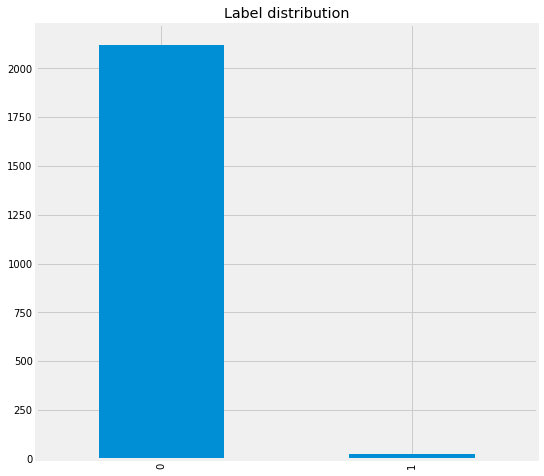

In [49]:
  df_draw = make_cutoffs(pd.datetime(1993, 1, 3))
  plt.figure(figsize=(8,8))
  df_draw['label'].value_counts().plot.bar();
  plt.title('Label distribution')

In [51]:
for dt in df.loc[df['draw_date'].dt.year >= START_YEAR]['draw_date'].unique():
  df_draw = make_cutoffs(dt)
  print(len(df_draw), len(df_draw.loc[df_draw['label'] == 1]))

9725 23
9725 23
9726 23
9726 23
9727 23
9728 22
9730 23
9730 23
9731 23
9732 23
9734 23
9734 23
9735 23
9736 23
9737 23
9737 23
9739 23
9739 23
9739 23
9739 23
9739 23
9739 23
9739 23
9739 23
9739 23
9740 23
9740 23
9740 23
9741 23
9742 23
9745 23
9745 23
9746 23
9747 23
9747 23
9749 23
9749 23
9749 23
9749 23
9749 23
9750 23
9750 23
9750 23
9751 23
9751 23
9751 23
9754 23
9754 23
9755 23
9755 23
9756 23
9756 23
9759 23
9761 23
9762 23
9763 23
9763 23
9764 23
9767 23
9767 23
9767 23
9769 23
9769 23
9769 23
9769 23
9769 23
9771 23
9771 23
9772 23
9772 23
9772 23
9773 23
9775 23
9776 23
9777 23
9779 23
9780 23
9780 23
9781 23
9782 23
9782 23
9782 23
9782 23
9782 23
9782 23
9783 23
9783 22
9783 23
9784 23
9785 23
9785 23
9786 23
9787 23
9789 23
9789 23
9789 23
9789 23
9789 23
9789 23
9789 23
9789 23
9789 23
9790 23
9792 23
9793 23
9793 23
9793 23
9793 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9794 23
9796 23
9797 23
9797 23
9798 23
9798 23


## Skewness of data

In [0]:
#  https://github.com/mengwangk/Automated-Manual-Comparison/blob/master/Retail%20Spending/notebooks/Automated%20Retail%20Spending.ipynb

In [0]:
def ecdf(data):
    """
    Empirical cumulative distribution function (ECDF) plot
    """
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [0]:
# d = df['LuckyNo'].astype(str)

In [0]:
# x, y = ecdf(d)
# plt.plot(x, y, marker = '.')
# plt.xlabel('Lucky No'); plt.ylabel('Percentile'); plt.title('ECDF of Lucky No');

### Generate new features

In [0]:
df = df.reset_index()

In [0]:
df.rename(columns={"index": "instance_id"}, inplace=True)
df.head(10)

,instance_id,DrawNo,DrawDate,PrizeType,LuckyNo,result_id
0,0,40792,1992-05-06,1stPrizeNo,19,19
1,1,40792,1992-05-06,2ndPrizeNo,1124,1124
2,2,40792,1992-05-06,3rdPrizeNo,592,592
3,3,40792,1992-05-06,ConsolationNo1,5311,5311
4,4,40792,1992-05-06,ConsolationNo10,407,407
5,5,40792,1992-05-06,ConsolationNo2,1949,1949
6,6,40792,1992-05-06,ConsolationNo3,1606,1606
7,7,40792,1992-05-06,ConsolationNo4,3775,3775
8,8,40792,1992-05-06,ConsolationNo5,6226,6226
9,9,40792,1992-05-06,ConsolationNo6,1271,1271


#### Cut off time

In [0]:
labels = df[["instance_id", "DrawDate"]].groupby(["instance_id", "DrawDate"]).min().reset_index()
labels.rename(columns = {"DrawDate":"cutoff_time"}, inplace=True)

/Users/mengwangk/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


In [0]:
labels.head(30)

,instance_id,cutoff_time
0,0,1992-05-06
1,1,1992-05-06
2,2,1992-05-06
3,3,1992-05-06
4,4,1992-05-06
5,5,1992-05-06
6,6,1992-05-06
7,7,1992-05-06
8,8,1992-05-06
9,9,1992-05-06


In [0]:
df.drop(columns=['instance_id'], inplace=True)

In [0]:
df.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,result_id
0,40792,1992-05-06,1stPrizeNo,19,19
1,40792,1992-05-06,2ndPrizeNo,1124,1124
2,40792,1992-05-06,3rdPrizeNo,592,592
3,40792,1992-05-06,ConsolationNo1,5311,5311
4,40792,1992-05-06,ConsolationNo10,407,407
5,40792,1992-05-06,ConsolationNo2,1949,1949
6,40792,1992-05-06,ConsolationNo3,1606,1606
7,40792,1992-05-06,ConsolationNo4,3775,3775
8,40792,1992-05-06,ConsolationNo5,6226,6226
9,40792,1992-05-06,ConsolationNo6,1271,1271


In [0]:
es = ft.EntitySet(id="Draw Results")

In [0]:
# Add the entire data table as an entity
es.entity_from_dataframe("results",
                         dataframe=df,
                         index="results_index",
                         time_index = 'DrawDate')

es['results']

2019-10-07 23:19:43,718 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
    result_id (dtype: numeric)
  Shape:
    (Rows: 104673, Columns: 6)

In [0]:
# Create a new entity
es.normalize_entity(new_entity_id="draws",
                    base_entity_id="results",
                    index="LuckyNo")
                    # additional_variables=[""])
es['draws'].df.head()

,LuckyNo,first_results_time
19,19,1992-05-06
407,407,1992-05-06
592,592,1992-05-06
950,950,1992-05-06
1124,1124,1992-05-06


In [0]:
es['results'].df.head(10)

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,result_id
0,0,40792,1992-05-06,1stPrizeNo,19,19
1,1,40792,1992-05-06,2ndPrizeNo,1124,1124
2,2,40792,1992-05-06,3rdPrizeNo,592,592
3,3,40792,1992-05-06,ConsolationNo1,5311,5311
4,4,40792,1992-05-06,ConsolationNo10,407,407
5,5,40792,1992-05-06,ConsolationNo2,1949,1949
6,6,40792,1992-05-06,ConsolationNo3,1606,1606
7,7,40792,1992-05-06,ConsolationNo4,3775,3775
8,8,40792,1992-05-06,ConsolationNo5,6226,6226
9,9,40792,1992-05-06,ConsolationNo6,1271,1271


In [0]:
es['draws'].df.loc[lambda df: df['LuckyNo'] == 19].head()

,LuckyNo,first_results_time
19,19,1992-05-06


In [0]:
es['results'].df.loc[lambda df: df['LuckyNo'] == 19].head()

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,result_id
0,0,40792,1992-05-06,1stPrizeNo,19,19
297,297,41992,1992-06-03,SpecialNo8,19,19
10813,10813,87795,1995-05-06,ConsolationNo1,19,19
11566,11566,90995,1995-07-19,SpecialNo7,19,19
14844,14844,105296,1996-06-16,ConsolationNo6,19,19


In [0]:
es

Entityset: Draw Results
  Entities:
    results [Rows: 104673, Columns: 6]
    draws [Rows: 10000, Columns: 2]
  Relationships:
    results.LuckyNo -> draws.LuckyNo

#### Generate features

In [0]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='results',
                                       cutoff_time = labels, verbose = 2,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = -1,
                                       max_depth = 1)

Built 8 features
EntitySet scattered to workers in 1.006 seconds
Elapsed: 01:16 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [0]:
feature_matrix.head(50)